In [1]:
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
import os
import scipy.signal
import fasttext

from nltk.tokenize import word_tokenize
from sklearn.metrics import f1_score,accuracy_score
from numba import jit, prange
from tqdm import tqdm
from vmdpy import VMD
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

os.chdir('../')
os.chdir('data/')

In [2]:
def format_text(df,col):
      comp_df = df.copy()
      # remove all the punctuation
      comp_df[col] = comp_df[col].str.replace(r'(@\w*)','')

      #Remove all non-character
      comp_df[col] = comp_df[col].str.replace(r"[^a-zA-Z ]","")

      # Remove extra space
      comp_df[col] = comp_df[col].str.strip()

      # Change to lowercase
      comp_df[col] = comp_df[col].str.lower()
      return comp_df

def energy(u):
# Estimate PSD `S_xx_welch` at discrete frequencies `f_welch`
    f_welch, S_xx_welch = scipy.signal.welch(u)
    # Integrate PSD over spectral bandwidth
    # to obtain signal power `P_welch`
    df_welch = f_welch[1] - f_welch[0]
    return np.sum(S_xx_welch) * df_welch  

def maxvdm(f):
    alpha = 2     
    tau = 0            
    K = 3       
    DC = 0             
    init = 1           
    tol = 1e-9
    u, u_hat, omega = VMD(f, alpha, tau, K, DC, init, tol) 
    energy_array=[]
    for i in u:
        energy_array.append(energy(i))
    ind = np.argmax(energy_array)
    return u[ind]


In [3]:
def tune(f,alpha,K):   
    tau = 0                 
    DC = 0             
    init = 1           
    tol = 1e-9
    u, u_hat, omega = VMD(f, alpha, tau, K, DC, init, tol) 
    energy_array=[]
    for i in u:
        energy_array.append(energy(i))
    ind = np.argmax(energy_array)
    return u[ind]

@jit(parallel=True,forceobj=True)
def tuning(features):
    f_dict={}
    acc_dict={}
    for k in tqdm(prange(2,7)):
        for al in prange(2,7):
            X = []
            for i in prange(len(features)):
                X.append(tune(features[i],al,k))
                
            X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.25)
            
            lr = LogisticRegression()
            lr.fit(X_train,y_train)
            y_pred = lr.predict(X_test)
            
            f = f1_score(y_test, y_pred)
            a = accuracy_score(y_test, y_pred)
            f_dict['K : '+str(k)+' Alpha : '+str(al)] = f
            acc_dict['K : '+str(k)+' Alpha : '+str(al)] = a
    
    return f_dict,acc_dict

## Loading IMdb Dataset:

In [4]:
imdb_data = pd.read_csv('IMDB.csv')

A sample of 5k rows from 50k is taken randomly for primary analysis

In [5]:
imdb_data_sam = imdb_data.sample(n=7000, replace=False)

train = format_text(imdb_data_sam,'review')
X = train['review'].tolist()
Y = train['sentiment']

In [6]:
le = LabelEncoder()
le.fit(Y)
y = le.transform(Y)

### TF-IDF Vectoriser

In [7]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(X).toarray()

#### Fine-Tuning Parameters for VMD Mode extraction

In [8]:
a,f = tuning(features)

### Extracting VMD Modes

In [10]:
@jit(parallel=True,forceobj=True)
def vm(features):
    X = np.zeros((features.shape[0],features.shape[1]))
    for i in tqdm(prange(len(features))):
        X[i]=maxvdm(features[i])
    return X

X_vmd = vm(features)

100%|██████████| 7000/7000 [7:13:31<00:00,  3.72s/it]  


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_vmd, y, test_size=0.25)

### Evaluating Model

In [12]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.77      0.81       875
           1       0.79      0.88      0.83       875

    accuracy                           0.82      1750
   macro avg       0.83      0.82      0.82      1750
weighted avg       0.83      0.82      0.82      1750



## FastText Pre-Trained Model

In [14]:
ft = fasttext.load_model('cc.en.300.bin')
size = ft.get_dimension()
corpus = []
for i in X:
    corpus.append(word_tokenize(i))

In [15]:
X_fast = np.zeros((len(corpus),size)) #Initializing the X matrix with zeros
for i in range(len(corpus)):
    emb = np.zeros((1,size))
    for w in corpus[i]:
        emb = emb +  ft.get_word_vector(w)
    X_fast[i] = emb

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_fast, y, test_size=0.25)
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       870
           1       0.82      0.80      0.81       880

    accuracy                           0.81      1750
   macro avg       0.81      0.81      0.81      1750
weighted avg       0.81      0.81      0.81      1750



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## t-SNE Plots for Semantic Relation-Analysis

In [17]:
VMD_embedded = TSNE(n_components=2).fit_transform(X_vmd.T)

In [44]:
words = tfidf.get_feature_names()

Randomdly selecting words in the VMD and fastText corpus to compare semantic

In [51]:
a

array([12914,  5156,  8283, 10689,  3637, 19394, 12667, 11499,  7811,
       12035,   598,  4548, 13413,  5768, 12985])

In [73]:
a

array([20973, 11912, 16622, 20096, 18483, 12464, 22025,  6267, 14180,
       11280, 23396,  5594, 15347, 20732, 13834])

In [186]:
a = np.random.randint(len(words), size=15)

In [187]:
word_vec=[]
word = []
for i in a:
    word_vec.append(ft.get_word_vector(words[i]))
    word.append(words[i])
fast = TSNE(n_components=2).fit_transform(word_vec)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

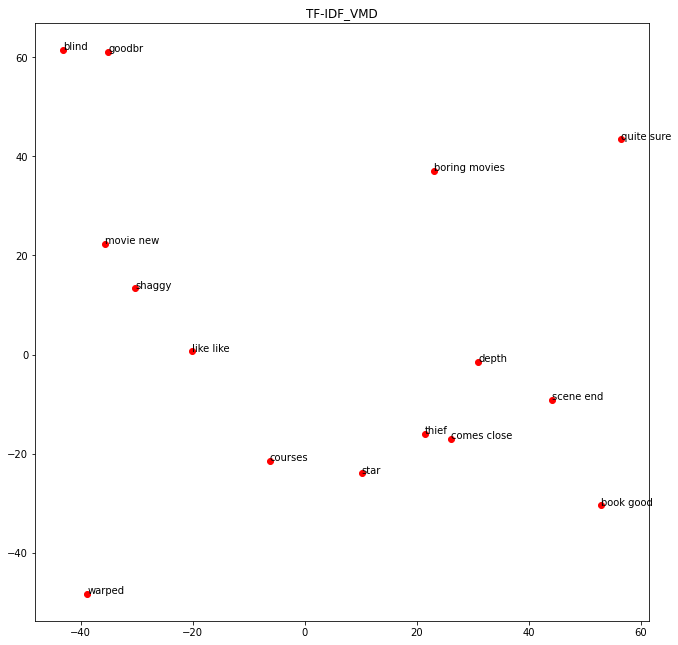

In [188]:
plt.figure(figsize=(11,11))
for i in a:
    plt.scatter(VMD_embedded[i][0], VMD_embedded[i][1], c='red')
    plt.annotate(words[i], VMD_embedded[i], xytext=None, xycoords='data', textcoords='data', arrowprops=None)
    plt.title("TF-IDF_VMD")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

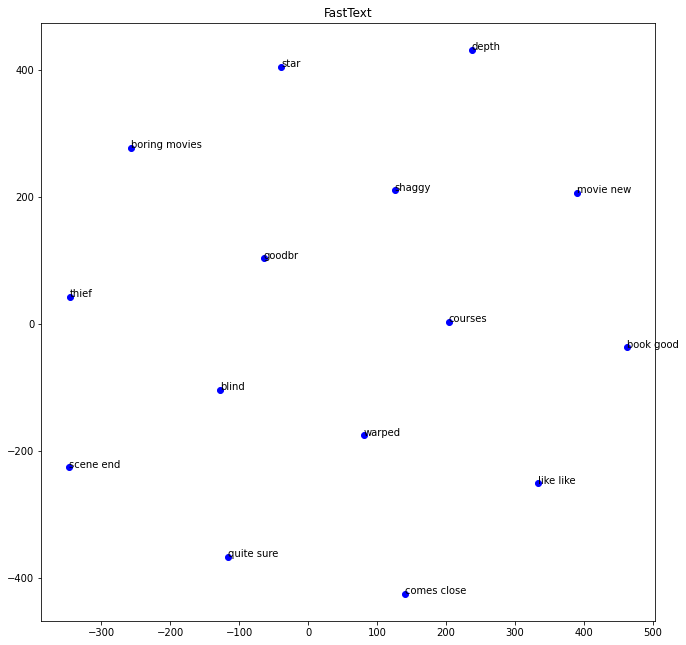

In [189]:
plt.figure(figsize=(11,11))
for i in range(len(fast)):
    plt.scatter(fast[i][0], fast[i][1], c='blue')
    plt.annotate(word[i], fast[i], xytext=None, xycoords='data', textcoords='data', arrowprops=None)
    plt.title("FastText")
plt.show()